In [1]:
from scripts import bookdatafunctions as bdf
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Constants

#In the deprel column
#Dependency relation types in Finnish UD
DEPRELS = ['root', 'nsubj', 'advmod', 'obl', 'obj', 'conj', 'aux', 'cc', 'amod', 'nmod:poss', 'mark', 'cop', 'nsubj:cop', 'advcl', 'xcomp', 'case', 'det', 'ccomp', 'nmod', 'parataxis', 'acl:relcl', 'acl', 'xcomp:ds', 'discourse', 'nummod', 'fixed', 'cop:own', 'appos', 'flat:name', 'compound:nn', 'aux:pass', 'vocative', 'nmod:gobj', 'nmod:gsubj', 'compound:prt', 'csubj:cop', 'flat:foreign', 'orphan', 'cc:preconj', 'csubj', 'compound', 'flat', 'goeswith']

#In the feats column
#Cases in Finnihs UD
CASES = ['Case=Nom', 'Case=Gen', 'Case=Par', 'Case=Ill', 'Case=Ine', 'Case=Ela', 'Case=Ade', 'Case=All', 'Case=Ess', 'Case=Abl', 'Case=Tra', 'Case=Acc', 'Case=Ins', 'Case=Abe', 'Case=Com']
#Verb forms in Finnish UD
VERBFORMS = ['VerbForm=Fin', 'VerbForm=Inf', 'VerbForm=Part']
#Verb tenses in Finnish UD
VERBTENSES = ['Tense=Pres', 'Tense=Past']
#Verb voices in Finnish UD
VERBVOICES = ['Voice=Act', 'Voice=Pass']
#Verb moods in Finnish UD
VERBMOODS = ['Mood=Ind', 'Mood=Cnd', 'Mood=Imp']
#Verb 'person' in Finnish UD (aka first person, second person and so on)
PERSONS = ['Person=0', 'Person=1', 'Person=2', 'Person=3']
#Verb 'number' in Finnish UD (aka first singluar person [me] or first plural person [we] and so on)
NUMBERS = ['Number=Sing', 'Number=Plur']
#Connegative (aka verb that has been given a negative meaning by 'ei')
CONNEGATIVE = ['Connegative=Yes']
#Degrees in Finnish UD (positive, comparative, and superlative)
DEGREES = ['Degree=Pos','Degree=Cmp','Degree=Sup']
FEATS = CASES + VERBFORMS + VERBTENSES + VERBVOICES + VERBMOODS + PERSONS + NUMBERS + CONNEGATIVE + DEGREES
#In the upos column
#POS tags in Finnish UD
POS = ['NOUN', 'VERB', 'PRON', 'ADV', 'AUX', 'ADJ', 'PROPN', 'CCONJ', 'SCONJ', 'ADP', 'NUM', 'INTJ']


ALL_FEATS = DEPRELS + FEATS + POS 


In [3]:
def tempDFGenerator(measures: dict[int, dict], name: str) -> pd.DataFrame:
    effect_size_12 = bdf.cohensdForSubcorps(measures[1], measures[2])
    effect_size_23 = bdf.cohensdForSubcorps(measures[2], measures[3])
    effect_size_13 = bdf.cohensdForSubcorps(measures[1], measures[3])

    return pd.DataFrame({"1-2":effect_size_12, "2-3":effect_size_23, "1-3":effect_size_13}, index=[name])

In [4]:

#Excel-file hosting information to map a book to its 'exact' intended reading age

ISBN2AGE_PATH = "ISBN_MAPS/ISBN2AGE.xlsx"

print("Start...")

#Load the corpus and, clean lemmas (remove Japanese characters, punctuation, etc.), and map books to their intended reading ages

books = bdf.mapGroup2Age(bdf.initBooksFromConllus("Conllus"), ISBN2AGE_PATH)

Start...


In [5]:
#Create three sub-corpora. 
# 
# Sub_1 has ages 5,6,7,8
# Sub_2 has ages 9,10,11,12
# Sub_3 has ages 13,14,15

sub_1 = bdf.combineSubCorpDicts([bdf.getRangeSubCorp(books, 6), bdf.getDistinctSubCorp(books, 8)])
sub_2 = bdf.combineSubCorpDicts([bdf.getRangeSubCorp(books, 10), bdf.getDistinctSubCorp(books, 12)])
sub_3 = bdf.getRangeSubCorp(books, 14)

sub_corps = {1:sub_1, 2:sub_2, 3:sub_3}

COMPARISONS = ["1-2", "2-3", "1-3"]

ef_sizes = []

In [6]:
def getPosPhraseCounts(corpus: dict[str,pd.DataFrame], upos: str) -> dict[str,int]:
    """
    Function for calculating the number of POS phrases for each book in (sub)corpus.
    Working POS-tags are those listed in the CoNLLU file format
    """
    returnable = {}
    for key in corpus:
        df = corpus[key]
        returnable[key] = len(df[(df['upos'] == upos) & (df['deprel'] == 'root')])
    return returnable

In [7]:
print(getPosPhraseCounts(sub_1, 'NOUN'))

{'9789523548817_5_2': 63, '9789511269830_7_3': 561, '9789523640580_7_1': 625, '9789511413813_7_1': 256, '9789513173487_5_1': 222, '9789515245908_6_1': 270, '9789520459833_7_2': 396, '9789510491645_5_2': 126, '9789520413453_5_2': 11, '9789523413405_7_1': 164, '9789520420505_5_2': 128, '9789520413620_5_1': 35, '9789513196462_5_1': 228, '9789511379010_6_1': 199, '9789523413597_6_2': 94, '9789526352916_7_3': 510, '9789515252760_6_1': 287, '9789515248794_6_1': 300, '9789511264774_5_1': 699, '9789511475316_6_2': 1275, '9789523543379_6_2': 295, '9789523730618_5_2': 922, '9789523703582_7_1': 268, '9789511425045_7_1': 540, '9789510421185_6_1': 60, '9789510446621_7_1': 165, '9789510427927_7_1': 598, '9789511372813_7_1': 242, '9789511439707_6_1': 284, '9789520423407_5_1': 44, '9789520419912_7_1': 198, '9789523514928_7_2': 380, '9789523640597_7_2': 200, '9789523795075_7_2': 180, '9789511274100_5_1': 701, '9789523416819_7_1': 158, '9789510447659_5_1': 126, '9789523415348_7_1': 165, '9789515251213_6

In [8]:


print("Processing dependency relations...")

#Basically map a feature that was listed above (in this case a dependency relation type)
#To the Cohen's D value gotten from analysing this feature between two sub-corpora
#This is where the Key Feature Analysis is done
#How these are calculated are in the functions used located in the 'bookdatafunctions.py' file in the 'Scripts' folder

deprel_effect_sizes_12 = {}
deprel_effect_sizes_13 = {}
deprel_effect_sizes_23 = {}

for deprel in DEPRELS:
    deprel_effect_sizes_12[deprel] = bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_1, deprel, True), bdf.getDeprelFeaturePerBook(sub_2, deprel, True))
    deprel_effect_sizes_13[deprel] = bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_1, deprel, True), bdf.getDeprelFeaturePerBook(sub_3, deprel, True))
    deprel_effect_sizes_23[deprel] = bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_2, deprel, True), bdf.getDeprelFeaturePerBook(sub_3, deprel, True))

ef_sizes.append(pd.DataFrame({"1-2":deprel_effect_sizes_12.values(), "2-3":deprel_effect_sizes_23.values(), "1-3":deprel_effect_sizes_13.values()}, index=deprel_effect_sizes_23.keys()))

print("Processing cases and verb-forms...")

#Same steps as before, just repeated for more features

feats_effect_sizes_12 = {}
feats_effect_sizes_13 = {}
feats_effect_sizes_23 = {}


for feat in FEATS:
    feats_effect_sizes_12[feat] = bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_1, feat, True), bdf.getFeatsFeaturePerBook(sub_2, feat, True))
    feats_effect_sizes_13[feat] = bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_1, feat, True), bdf.getFeatsFeaturePerBook(sub_3, feat, True))
    feats_effect_sizes_23[feat] = bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_2, feat, True), bdf.getFeatsFeaturePerBook(sub_3, feat, True))

ef_sizes.append(pd.DataFrame({"1-2":feats_effect_sizes_12.values(), "2-3":feats_effect_sizes_23.values(), "1-3":feats_effect_sizes_13.values()}, index=feats_effect_sizes_23.keys()))

print("Processing POS features...")

#Same steps as before, just repeated for POS-tags

pos_effect_sizes_12 = {}
pos_effect_sizes_13 = {}
pos_effect_sizes_23 = {}

for pos in POS:
    pos_effect_sizes_12[pos] = bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_1, pos, True), bdf.getPosFeaturePerBook(sub_2, pos, True))
    pos_effect_sizes_13[pos] = bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_1, pos, True), bdf.getPosFeaturePerBook(sub_3, pos, True))
    pos_effect_sizes_23[pos] = bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_2, pos, True), bdf.getPosFeaturePerBook(sub_3, pos, True))

ef_sizes.append(pd.DataFrame({"1-2":pos_effect_sizes_12.values(), "2-3":pos_effect_sizes_23.values(), "1-3":pos_effect_sizes_13.values()}, index=pos_effect_sizes_23.keys()))
#Separate this old garbage code from the better stuff written down below :)

Processing dependency relations...
Processing cases and verb-forms...
Processing POS features...


In [15]:
#I also take a look at the Type-Token Ratios of the sub-corpora and include that in the KFA
#Again, how the functions work can be found from the corresponding functions in 'bookdatafunctions.py'

lemma_freqs = bdf.getLemmaFrequencies(books)

print("Processing raw numbers...")

word_freqs = {}
word_amounts = {}
ttrs = {}
mls = {}
conj2sent = {}
sent_amounts = {}
noun_phrases = {}
verb_phrases = {}
adj_phrases = {}
adv_phrases = {}
noun_phrases_per_sent = {}
verb_phrases_per_sent = {}
adj_phrases_per_sent = {}
adv_phrases_per_sent = {}
for sub in sub_corps:
    word_freqs[sub] = bdf.getWordFrequencies(sub_corps[sub])
    word_amounts[sub] = bdf.getTokenAmounts(sub_corps[sub])
    ttrs[sub] = bdf.getTypeTokenRatios(word_freqs[sub], word_amounts[sub]).to_dict()
    mls[sub] = bdf.getAvgSentenceLens(sub_corps[sub])
    conj2sent[sub] = bdf.getConjPerSentence(sub_corps[sub])
    sent_amounts[sub] = bdf.getNumOfSentences(sub_corps[sub])
    noun_phrases[sub] = bdf.getPosPhraseCounts(sub_corps[sub], 'NOUN')
    verb_phrases[sub] = bdf.getPosPhraseCounts(sub_corps[sub], 'VERB')
    adj_phrases[sub] = bdf.getPosPhraseCounts(sub_corps[sub], 'ADJ')
    adv_phrases[sub] = bdf.getPosPhraseCounts(sub_corps[sub], 'ADV')
    noun_phrases_per_sent[sub] = bdf.scaleCorpusData(noun_phrases[sub],sent_amounts[sub])
    verb_phrases_per_sent[sub] = bdf.scaleCorpusData(verb_phrases[sub],sent_amounts[sub])
    adj_phrases_per_sent[sub] = bdf.scaleCorpusData(adj_phrases[sub],sent_amounts[sub])
    adv_phrases_per_sent[sub] = bdf.scaleCorpusData(adv_phrases[sub],sent_amounts[sub])



Processing raw numbers...


In [17]:

print("Processing effect sizes...")
ef_sizes.append(tempDFGenerator(ttrs, 'TTR'))
ef_sizes.append(tempDFGenerator(mls, 'MLS'))
ef_sizes.append(tempDFGenerator(conj2sent, 'C2S'))
ef_sizes.append(tempDFGenerator(noun_phrases_per_sent, 'NPS'))
ef_sizes.append(tempDFGenerator(verb_phrases_per_sent, 'VPS'))
ef_sizes.append(tempDFGenerator(adj_phrases_per_sent, 'ADJPS'))
ef_sizes.append(tempDFGenerator(adv_phrases_per_sent, 'ADVPS'))


#Combine all the effect sizes into a Pandas Dataframe, so that it is easy to have it all in one place
#This dataframe has features as indexes and names of the sub-coprora compared as the columns (so e.g. "1-2" for the KFA results between sub coprus 1 and sub corpus 2)

effect_sizes = pd.concat(ef_sizes)


f_lemma = bdf.combineFrequencies(lemma_freqs)

Processing effect sizes...


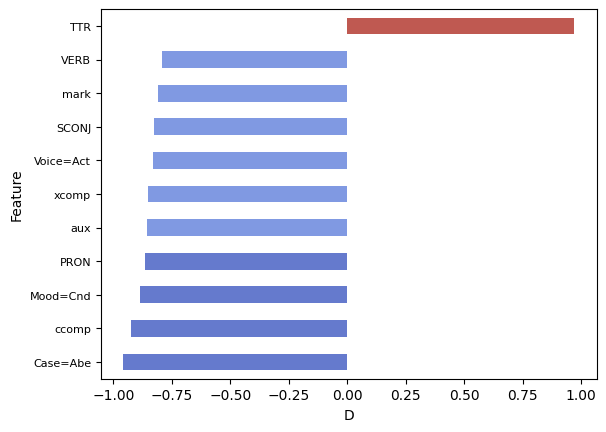

In [21]:
import matplotlib.pyplot as plt
import numpy as np

#Some plotting stuff for visualization. Not cleaned and will change in the future, but it works so it's fine :)
#This is the plot for KFA on subcorpora 1 and 2
#Positive (red) values mean that the feature is more prevalent in sub corpus 1, where as neagitve (blue) values mean its more prevalent in sub corpus 2
plot_12_df = pd.DataFrame({"D":effect_sizes['1-2'].values, "Feature":effect_sizes.index})
plot_12_df = plot_12_df[((plot_12_df['D'] < -0.79) | (plot_12_df['D'] > 0.79))]
plot_12_df = plot_12_df.sort_values(by="D", ascending=False)

def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)


fig, ax = plt.subplots()
ax = sns.barplot(plot_12_df, x="D", y="Feature", legend=False, width=0.5, palette=colors_from_values(plot_12_df['D'].values, "coolwarm"))
ax.tick_params(axis='y', labelsize=8)
plt.setp(ax.patches, linewidth=1)
plt.show()
#g.xticks(data['batch_no'][::50])


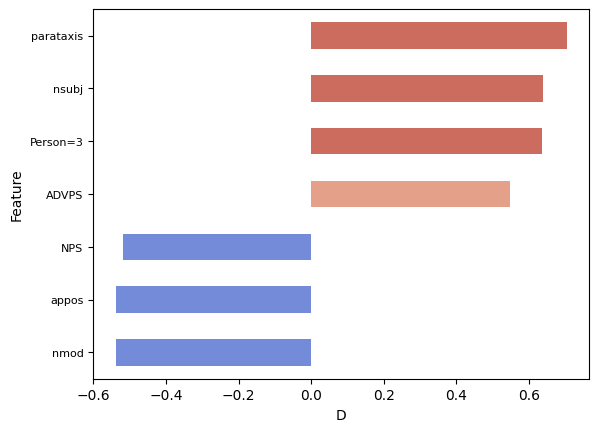

In [23]:
#This is the plot for KFA on subcorpora 2 and 3
plot_23_df = pd.DataFrame({"D":effect_sizes['2-3'].values, "Feature":effect_sizes.index})
plot_23_df = plot_23_df[((plot_23_df['D'] < -0.49) | (plot_23_df['D'] > 0.49))]
plot_23_df = plot_23_df.sort_values(by="D", ascending=False)

fig, ax = plt.subplots()
ax = sns.barplot(plot_23_df, x="D", y="Feature", legend=False, width=0.5, palette=colors_from_values(plot_23_df['D'].values, "coolwarm"))
ax.tick_params(axis='y', labelsize=8)
plt.setp(ax.patches, linewidth=1)
plt.show()


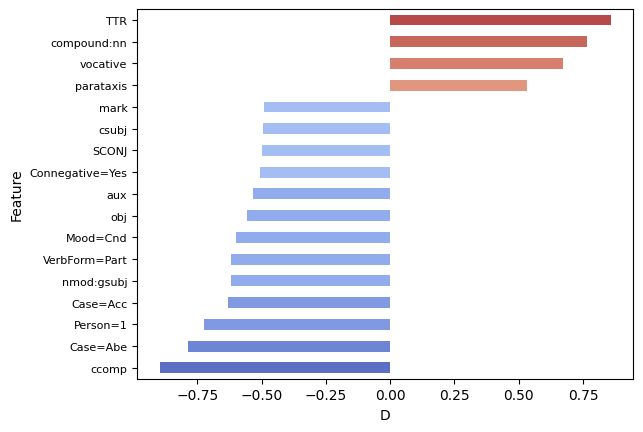

In [24]:
#This is the plot for KFA on subcorpora 1 and 3
plot_13_df = pd.DataFrame({"D":effect_sizes['1-3'].values, "Feature":effect_sizes.index})
plot_13_df = plot_13_df[((plot_13_df['D'] < -0.49) | (plot_13_df['D'] > 0.49))]
plot_13_df = plot_13_df.sort_values(by="D", ascending=False)

fig, ax = plt.subplots()
ax = sns.barplot(plot_13_df, x="D", y="Feature", legend=False, width=0.5, palette=colors_from_values(plot_13_df['D'].values, "coolwarm"))
ax.tick_params(axis='y', labelsize=8)
plt.setp(ax.patches, linewidth=1)
plt.show()
